In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pwd

/aiffel/aiffel/kaggle_kakr_housing


In [3]:
data_path = "/aiffel/aiffel/kaggle_kakr_housing/data/"

In [4]:
train_data_path = join(data_path, 'train.csv')
sub_data_path = join(data_path, 'test.csv')

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [5]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [6]:
y = data['price']

del data['price']

In [7]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [8]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

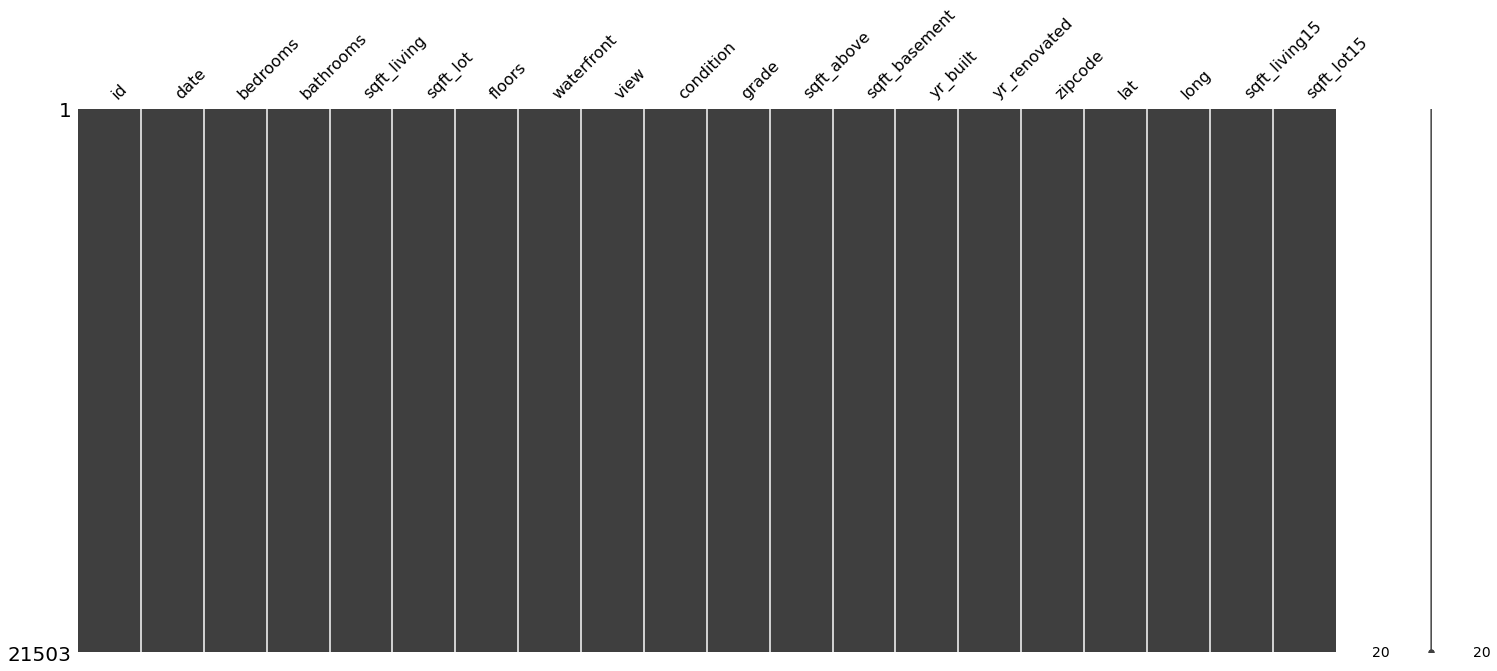

In [9]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [10]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [11]:
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype('int')

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21503 non-null  int64  
 1   bedrooms       21503 non-null  int64  
 2   bathrooms      21503 non-null  float64
 3   sqft_living    21503 non-null  int64  
 4   sqft_lot       21503 non-null  int64  
 5   floors         21503 non-null  float64
 6   waterfront     21503 non-null  int64  
 7   view           21503 non-null  int64  
 8   condition      21503 non-null  int64  
 9   grade          21503 non-null  int64  
 10  sqft_above     21503 non-null  int64  
 11  sqft_basement  21503 non-null  int64  
 12  yr_built       21503 non-null  int64  
 13  yr_renovated   21503 non-null  int64  
 14  zipcode        21503 non-null  int64  
 15  lat            21503 non-null  float64
 16  long           21503 non-null  float64
 17  sqft_living15  21503 non-null  int64  
 18  sqft_lo

In [13]:
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


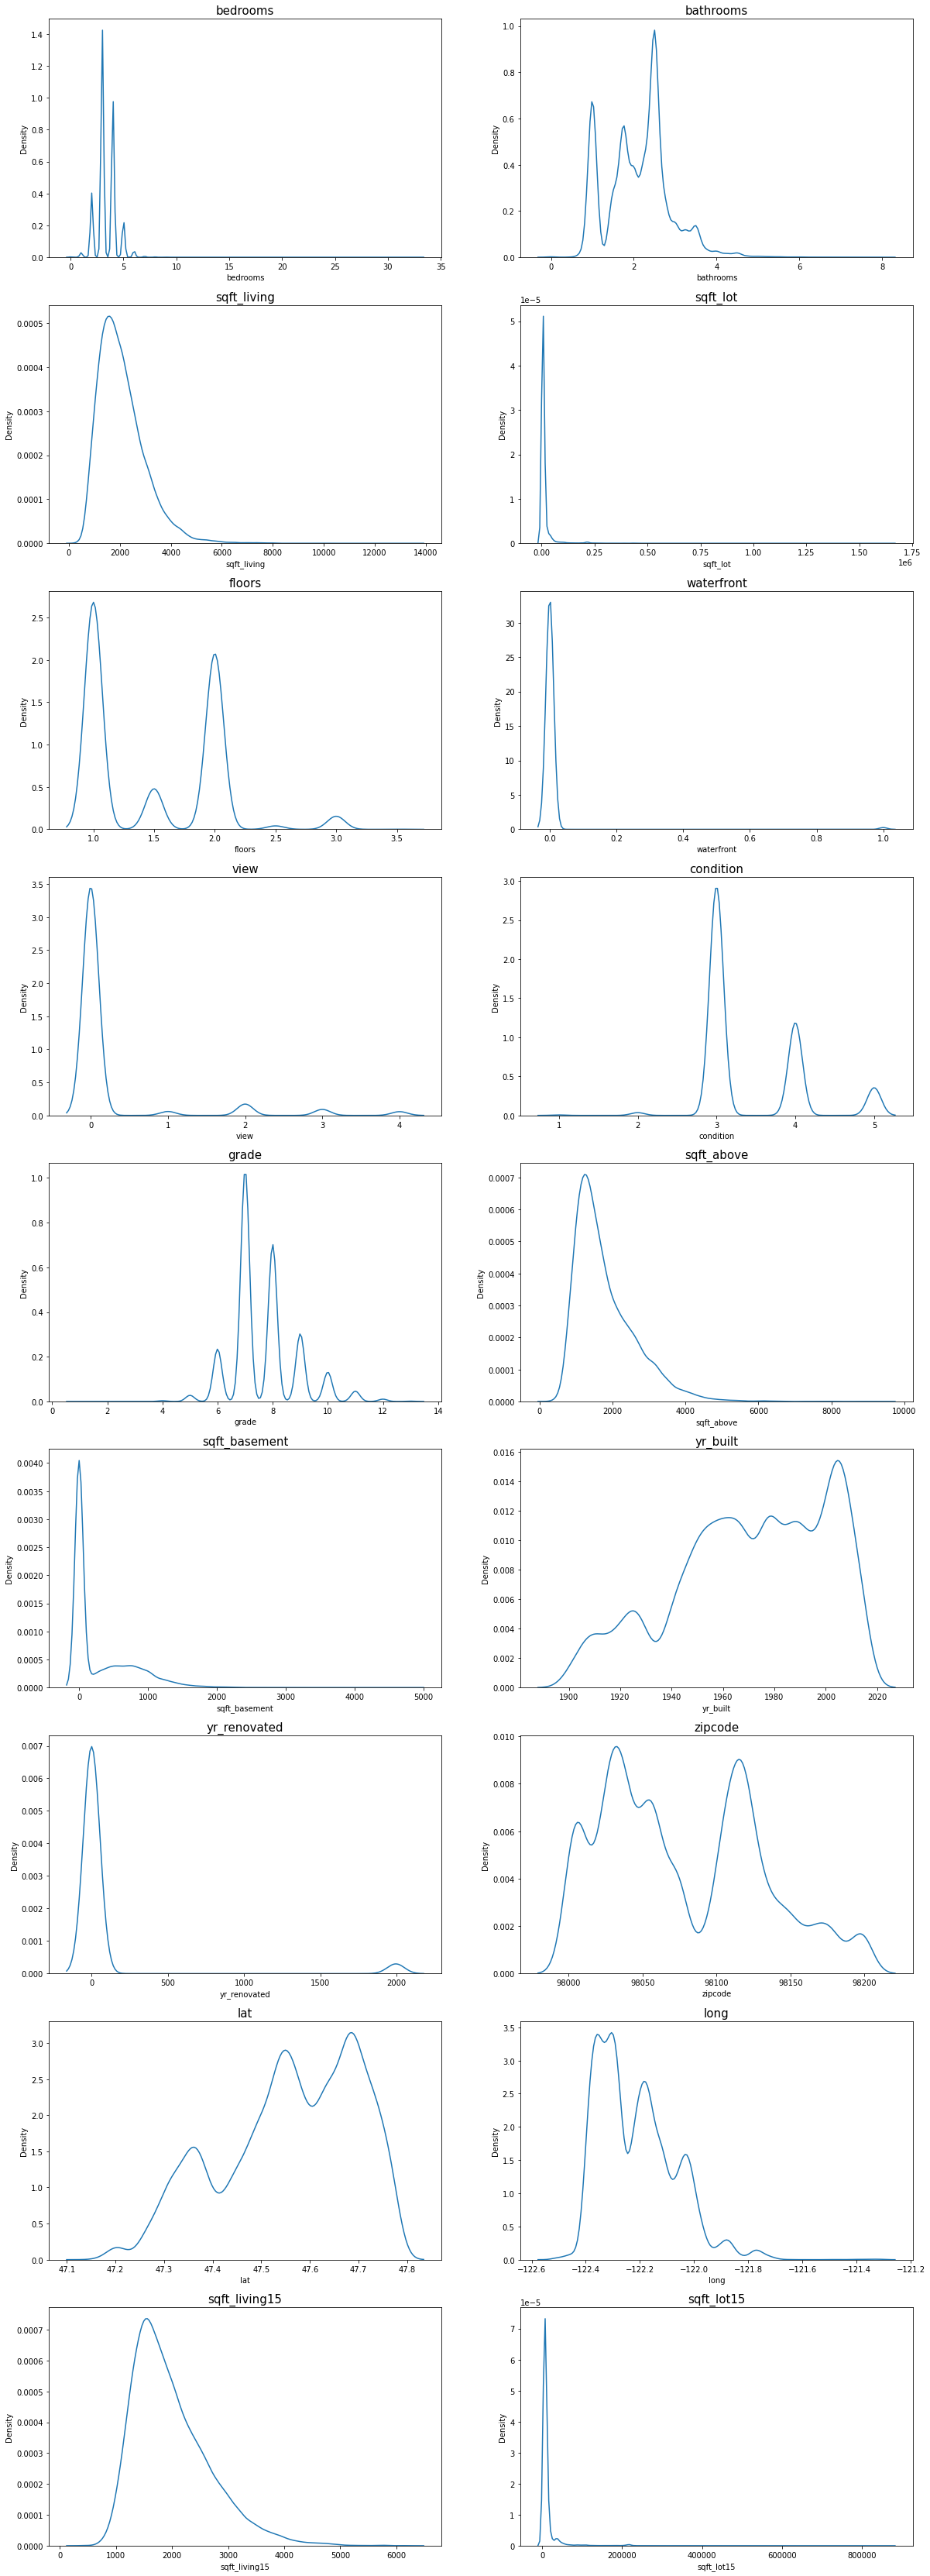

In [14]:
fig, ax = plt.subplots(9, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data = data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [15]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

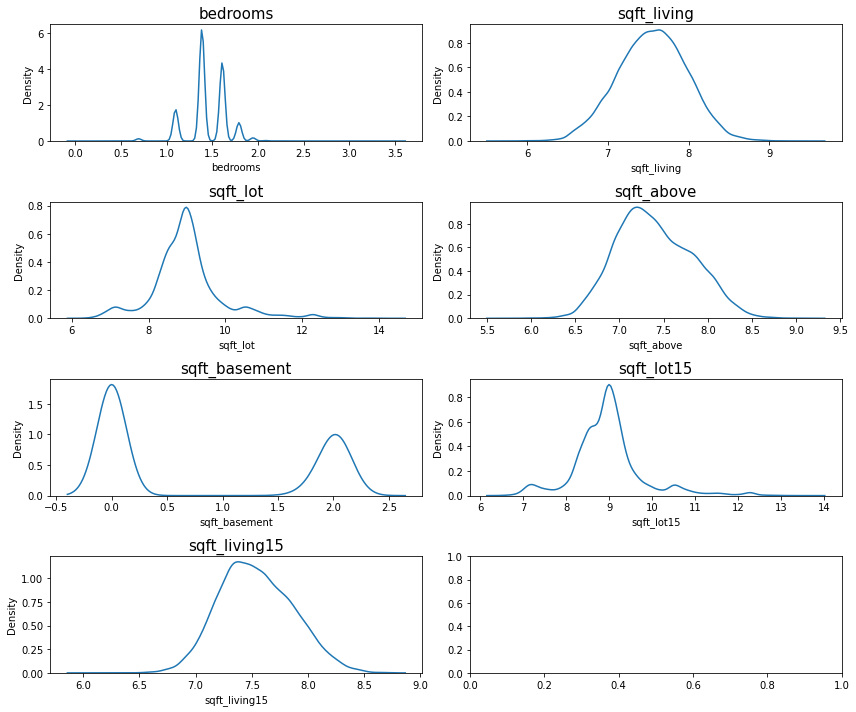

In [16]:
fig, ax = plt.subplots(4, 2, figsize=(12, 10))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 0
columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']
for row in range(4):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 7 :
            break

plt.tight_layout()

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [17]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


In [18]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Density'>

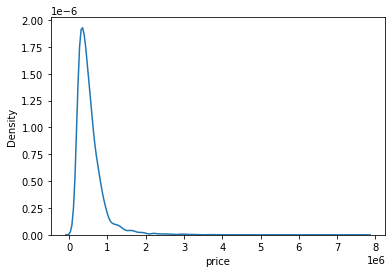

In [19]:
sns.kdeplot(y, data= x)

In [20]:
y = np.log1p(y)

In [21]:
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

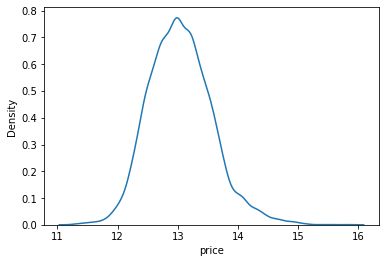

In [22]:
sns.kdeplot(y)
plt.show()

In [23]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  float64
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  float64
 4   sqft_lot       15035 non-null  float64
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  float64
 11  sqft_basement  15035 non-null  float64
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  float64
 18  sqft_l

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [25]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [26]:
random_state=2020 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [27]:
gboost.__class__.__name__

x.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [28]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, x, y)

,RMSE
GradientBoostingRegressor,128370.486911
RandomForestRegressor,125300.281172
LGBMRegressor,111906.268088
XGBRegressor,110319.723794


In [29]:
from sklearn.model_selection import GridSearchCV

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    fitting_results = grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    best_model = fitting_results.best_estimator_
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results, best_model

#### lightgbm

In [30]:
# 0.161021
param_grid = {
    'max_depth': [1, 10],
    'learning_rate' : [0.1, 0.05, 0.01],
    'n_estimators' : [50, 100, 500, 1000]
}
'''
# 300fit 시간이 오래 걸림
param_grid = {
    'max_depth': [1, 10, 20],
    'learning_rate' : [0.1, 0.05, 0.01, 0.001],
    'n_estimators' : [50, 100, 500, 1000, 5000]
}
'''
model = lightgbm
my_GridSearch(model, x, y, param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


(    learning_rate  max_depth  n_estimators     score     RMSLE
 14           0.05         10           500 -0.025928  0.161021
 15           0.05         10          1000 -0.025930  0.161027
 6            0.10         10           500 -0.026241  0.161992
 23           0.01         10          1000 -0.026687  0.163362
 7            0.10         10          1000 -0.026738  0.163518
 5            0.10         10           100 -0.027024  0.164391
 22           0.01         10           500 -0.029066  0.170488
 4            0.10         10            50 -0.029174  0.170804
 13           0.05         10           100 -0.029227  0.170958
 3            0.10          1          1000 -0.036512  0.191080
 12           0.05         10            50 -0.037336  0.193226
 2            0.10          1           500 -0.039043  0.197593
 11           0.05          1          1000 -0.039046  0.197600
 10           0.05          1           500 -0.043448  0.208442
 1            0.10          1           

In [31]:
model = LGBMRegressor(learning_rate=0.05, max_depth=10, n_estimators=500, random_state=2020)
model.fit(x, y)
prediction = model.predict(sub)
prediction

array([13.07368107, 13.09170761, 14.14209656, ..., 13.08250305,
       12.69985248, 12.96820835])

In [32]:
prediction = np.expm1(prediction)
prediction

array([ 476240.8402216 ,  484903.67768145, 1386226.45945987, ...,
        480460.82171205,  327698.55645539,  428568.56542495])

In [33]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [34]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,4.762408e+05
1,15036,4.849037e+05
2,15037,1.386226e+06
3,15038,2.987208e+05
4,15039,3.262536e+05


In [129]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.161021')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.161021.csv
